# Swish-based classifier using cosine-annealed LR with restarts and data augmentation
- Swish activation, 4 layers, 100 neurons per layer
- LR using cosine-annealing with restarts and cycle multiplicity of 2
- Data is augmentaed via phi rotations, and transvers and longitudinal flips
- Validation score use ensemble of 10 models weighted by loss

### Import modules

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
from __future__ import division
import sys
import os
sys.path.append('../')
from modules.basics import *
from modules.class_basics import *

Using TensorFlow backend.


In [2]:
DATA_PATH = Path('../data/')

## Options

In [3]:
with open(DATA_PATH/'feats.pkl', 'rb') as fin:
    train_feats = pickle.load(fin)

In [10]:
n_models = 10
patience = 50
max_epochs = 200

ensemble_size = 10
ensemble_mode = 'loss'

compile_args = {'loss':'binary_crossentropy', 'optimizer':'adam'}
train_params = {'epochs' : 1, 'batch_size' : 256, 'verbose' : 0}
model_params = {'version':'modelSwish', 'n_in':len(train_feats), 'compile_args':compile_args, 'mode':'classifier'}

print ("\nTraining on", len(train_feats), "features:", [var for var in train_feats])


Training on 30 features: ['DER_mass_MMC', 'DER_mass_transverse_met_lep', 'DER_mass_vis', 'DER_pt_h', 'DER_deltaeta_jet_jet', 'DER_mass_jet_jet', 'DER_prodeta_jet_jet', 'DER_deltar_tau_lep', 'DER_pt_tot', 'DER_sum_pt', 'DER_pt_ratio_lep_tau', 'DER_met_phi_centrality', 'DER_lep_eta_centrality', 'PRI_met_pt', 'PRI_met_sumet', 'PRI_jet_num', 'PRI_jet_all_pt', 'PRI_tau_px', 'PRI_tau_py', 'PRI_tau_pz', 'PRI_lep_px', 'PRI_lep_pz', 'PRI_jet_leading_px', 'PRI_jet_leading_py', 'PRI_jet_leading_pz', 'PRI_jet_subleading_px', 'PRI_jet_subleading_py', 'PRI_jet_subleading_pz', 'PRI_met_px', 'PRI_met_py']


## Import data

In [11]:
with open(DATA_PATH/'input_pipe.pkl', 'rb') as fin:
    input_pipe = pickle.load(fin)

In [12]:
train_fy = FoldYielder(h5py.File(DATA_PATH/'train.hdf5', "r+"))

## Determine LR

2 classes found, running in binary mode



/Users/giles/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)
No handles with labels found to put in legend.



______________________________________
Training finished
Cross-validation took 10.628s 


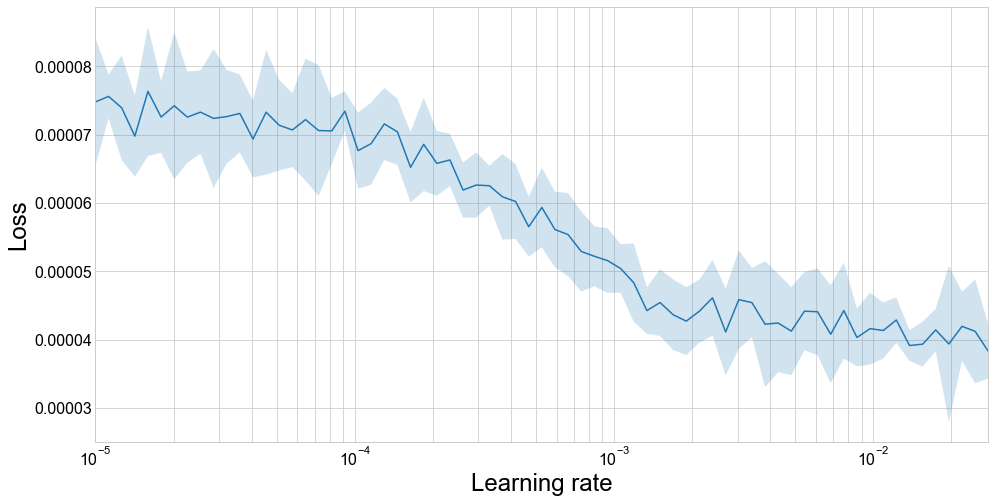

______________________________________



In [7]:
lr_finder = fold_lr_find(train_fy, get_model, model_params, train_params,
                         lr_bounds=[1e-5,1e-1], train_on_weights=True, verbose=0)

## Train classifier

In [13]:
model_gen_params = {**model_params, 'compile_args':{**compile_args, 'lr':2e-3}}
use_callbacks = {}
ams_args = {'n_total':250000, 'br':10, 'delta_b':0}
plots = ['history', 'lr']

Training using weights
Training model 1 / 10
2 classes found, running in binary mode

1 New best found: 3.5689583542053014e-05
2 New best found: 3.449168439901503e-05
3 New best found: 3.423488263454e-05
5 New best found: 3.390977222002897e-05
6 New best found: 3.316447034854822e-05
7 New best found: 3.268162024799143e-05
11 New best found: 3.235830663884805e-05
14 New best found: 3.2325236129009025e-05
20 New best found: 3.216107123995289e-05
23 New best found: 3.213385392550497e-05
26 New best found: 3.212942833092513e-05
27 New best found: 3.191413482889699e-05
31 New best found: 3.184368023450184e-05
34 New best found: 3.181026964994713e-05
65 New best found: 3.17537640100111e-05
75 New best found: 3.1730607929540614e-05
76 New best found: 3.1631136418523426e-05
Early stopping after 126 epochs
Score is: {'loss': 3.1631136418523426e-05, 'wAUC': 0.06257165201685577, 'AUC': 0.10279699019533328, 'AMS': 3.7389964555136186, 'cut': 0.9497801065444946}
Fold took 74.504s

Training model 2 /

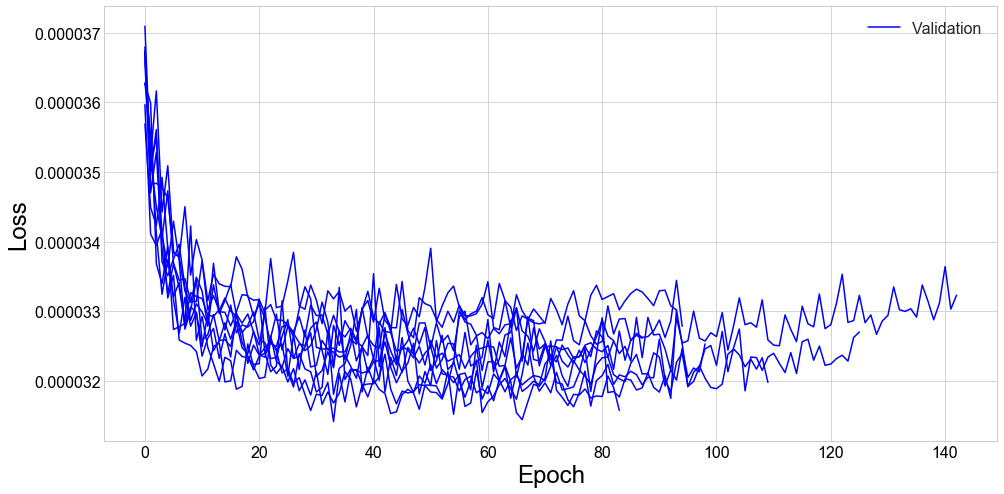

Mean loss = 3.2e-05 +- 1e-07
Mean wAUC = 0.0642 +- 0.0005
Mean AUC = 0.1024 +- 0.001
Mean AMS = 3.78 +- 0.08
Mean cut = 0.949 +- 0.005
______________________________________



<Figure size 432x288 with 0 Axes>

In [14]:
results, histories = fold_train_model(train_fy, n_models,
                                      model_gen_params=model_gen_params,
                                      train_params=train_params, train_on_weights=True,
                                      use_callbacks=use_callbacks, ams_args=ams_args,
                                      max_epochs=max_epochs, patience=patience,
                                      verbose=1, plots=plots)

The impact of data augmentation is pretty clear. Comparing the training here to that of the the CRL Swish model without augmentation we can see that we effectively gain another LR cycles worth of training epochs before we start overfitting, which allows the networks to reach much lower looses (3.18e-5 c.f. 3.23e-5) and a higher AMSs (3.98 c.f. 3.71)

## Construct ensemble

In [15]:
with open('train_weights/resultsFile.pkl', 'rb') as fin:   
    results = pickle.load(fin)

In [16]:
ensemble, weights = assemble_ensemble(results, ensemble_size, ensemble_mode, compile_args)

Choosing ensemble by loss
Model 0 is 6 with loss = 3.141933672896223e-05
Model 1 is 7 with loss = 3.154844882781108e-05
Model 2 is 0 with loss = 3.1631136418523426e-05
Model 3 is 9 with loss = 3.181592912878841e-05
Model 4 is 4 with loss = 3.204081729927566e-05
Model 5 is 5 with loss = 3.209377892931625e-05
Model 6 is 8 with loss = 3.2152028008597516e-05
Model 7 is 2 with loss = 3.226774471247547e-05
Model 8 is 1 with loss = 3.251815894473111e-05
Model 9 is 3 with loss = 3.270235000818502e-05


## Response on validation data

In [17]:
val_fy = FoldYielder(h5py.File(DATA_PATH/'val.hdf5', "r+"))

In [18]:
fold_ensemble_predict(ensemble, weights, val_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.0017088789855999494s per sample

Predicting fold 2 out of 10
Prediction took 0.0002917068224000104s per sample

Predicting fold 3 out of 10
Prediction took 0.0002740791172000172s per sample

Predicting fold 4 out of 10
Prediction took 0.0002770829061999393s per sample

Predicting fold 5 out of 10
Prediction took 0.0002980284262001078s per sample

Predicting fold 6 out of 10
Prediction took 0.0002984770410002966s per sample

Predicting fold 7 out of 10
Prediction took 0.0002966042174000904s per sample

Predicting fold 8 out of 10
Prediction took 0.0002906342583999503s per sample

Predicting fold 9 out of 10
Prediction took 0.00027978615800020636s per sample

Predicting fold 10 out of 10
Prediction took 0.00030564415019980517s per sample



In [19]:
print('Testing ROC AUC: unweighted {}, weighted {}'.format(roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source)),
                                                           roc_auc_score(get_feature('targets', val_fy.source), get_feature('pred', val_fy.source), sample_weight=get_feature('weights', val_fy.source))))

Testing ROC AUC: unweighted 0.9016652805010599, weighted 0.9356649616964148


In [20]:
ams_scan_slow(convert_to_df(val_fy.source), br=10, w_factor=250000/50000)

50000 candidates loaded


(3.8611284909083827, 0.9398072)

In [21]:
%%time
bootstrap_mean_calc_ams(convert_to_df(val_fy.source), br=10, w_factor=250000/50000, N=512)

50000 candidates loaded

Mean calc_ams=4.0+-0.2, at mean cut of 0.95+-0.02
Exact mean cut 0.9525760865071788, corresponds to calc_ams of 3.707312014807632
CPU times: user 3.58 s, sys: 5.23 s, total: 8.81 s
Wall time: 1min 40s


(4.0, 0.95)

# Test scoring

In [22]:
test_fy = FoldYielder(h5py.File(DATA_PATH/'testing.hdf5', "r+"))

In [23]:
%%time
fold_ensemble_predict(ensemble, weights, test_fy, ensemble_size=ensemble_size, verbose=1)

Predicting fold 1 out of 10
Prediction took 0.00028429695329091785s per sample

Predicting fold 2 out of 10
Prediction took 0.00028447652541819314s per sample

Predicting fold 3 out of 10
Prediction took 0.0002795291340909237s per sample

Predicting fold 4 out of 10
Prediction took 0.00028454689107275047s per sample

Predicting fold 5 out of 10
Prediction took 0.000281876639145445s per sample

Predicting fold 6 out of 10
Prediction took 0.0002775108168727456s per sample

Predicting fold 7 out of 10
Prediction took 0.00027915853889092185s per sample

Predicting fold 8 out of 10
Prediction took 0.00027120614349091323s per sample

Predicting fold 9 out of 10
Prediction took 0.00027638394485455305s per sample

Predicting fold 10 out of 10
Prediction took 0.0002831675399091182s per sample

CPU times: user 2min 51s, sys: 14.9 s, total: 3min 6s
Wall time: 2min 34s


In [24]:
score_test_data(test_fy.source, 0.9525760865071788)

Public:Private AMS: 3.713021941444702 : 3.7215111140279387


(3.713021941444702, 3.7215111140279387)

# Save/Load

In [ ]:
name = "weights/Swish_CLR_TTA"

In [ ]:
saveEnsemble(name, ensemble, weights, compile_args, overwrite=1)

In [ ]:
ensemble, weights, compile_args, _, _ = loadEnsemble(name)